<a href="https://colab.research.google.com/github/MichaelTj02/ComputerVision_Group17/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing required Libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

In [3]:
#Michael's dataset location
test_dir = '/content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/val'
train_dir = '/content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/train'

In [ ]:
#Ryan's dataset location
test_dir = '/content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/val'
train_dir = '/content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/train'

We need to map labels to class_ids required for YOLO

In [4]:
#train
df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

#val
df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

In [5]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax


In [6]:
label_map = { 'with helmet': 0,
            'without helmet': 1,
            'rider': 2,
            'number plate': 3}

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [7]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class


convertig the bounding box format to the one required by YOLO:




In [8]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [9]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height


converting the dataframe to type *str* (string) to be stored in text files.

In [10]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

# Custom object detection using YOLO

First install and import

In [11]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/112.6 GB disk)


In [12]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [13]:
model = YOLO('yolov8s.pt') # pretrained model

100%|██████████| 21.5M/21.5M [00:00<00:00, 122MB/s] 


The detailed architecture of the model can be seen from:


In [14]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

**Michael's Path**

In [16]:
%%writefile config.yaml
path: /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset
train: /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train
#test: (test dataset folder path)
val: /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/val

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: with helmet
  1: without helmet
  2: rider
  3: number plate

Overwriting config.yaml


**Ryan's Path**

In [15]:
%%writefile config.yaml

path: /content/drive/MyDrive/ComputerVisionProject
train: /content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/train
#test: (test dataset folder path)
val: /content/drive/MyDrive/ComputerVisionProject/ComputerVisionDataset/images/val

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: with helmet
  1: without helmet
  2: rider
  3: number plate

Writing config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [17]:
model.train(data="config.yaml",epochs=5,patience=5,batch=8, lr0=0.0005,imgsz=640)

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

100%|██████████| 755k/755k [00:00<00:00, 12.5MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 51.1MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/labels/train.cache... 143 images, 0 backgrounds, 2 corrupt: 100%|██████████| 145/145 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train/new128.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train/new128.jpg'
train: WARNING ⚠️ /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/images/train/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tiff', 'heic', 'bmp', 'jpg', 'webp', 'tif', 'dng', 'png', 'mpo', 'pfm', 'jpeg'}
videos: {'wmv', 'mpeg', 'ts', 'mp4', 'webm', 'm4v', 'asf', 'mpg', 'mov', 'avi', 'gif', 'mkv'}


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      2.18G      1.292      2.735      1.432         54        640: 100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.28s/it]

                   all         40        182      0.597       0.62       0.61       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G      1.042      1.298      1.189         60        640: 100%|██████████| 18/18 [00:04<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


                   all         40        182       0.71      0.723      0.765      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.09G     0.9668      1.088      1.128         50        640: 100%|██████████| 18/18 [00:05<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.32it/s]

                   all         40        182      0.755      0.685      0.766      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.16G     0.9103     0.8981      1.097         56        640: 100%|██████████| 18/18 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

                   all         40        182      0.822      0.722      0.819      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.1G     0.9609     0.8777      1.126         68        640: 100%|██████████| 18/18 [00:04<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]

                   all         40        182      0.786      0.784      0.832      0.578



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


                   all         40        182      0.786      0.784      0.832      0.577
           with helmet         23         31      0.754      0.888      0.897      0.608
        without helmet         20         39      0.804      0.632      0.698      0.453
                 rider         40         60      0.724      0.883      0.904      0.719
          number plate         38         52      0.864      0.732      0.827      0.526
Speed: 0.2ms preprocess, 8.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e75c1672680>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [18]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,127,132 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/drive/MyDrive/SFU/300 Level Courses/IAT360/ComputerVisionProject/ComputerVisionDataset/labels/val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


                   all         40        182      0.787      0.786      0.833      0.579
           with helmet         23         31      0.755      0.893      0.901      0.602
        without helmet         20         39      0.805      0.633      0.698      0.458
                 rider         40         60      0.723      0.883      0.906       0.72
          number plate         38         52      0.864      0.736      0.827      0.535
Speed: 2.2ms preprocess, 28.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train2


0.786416312227663

Showing confusion matrix, that is already stored in detect/train folder

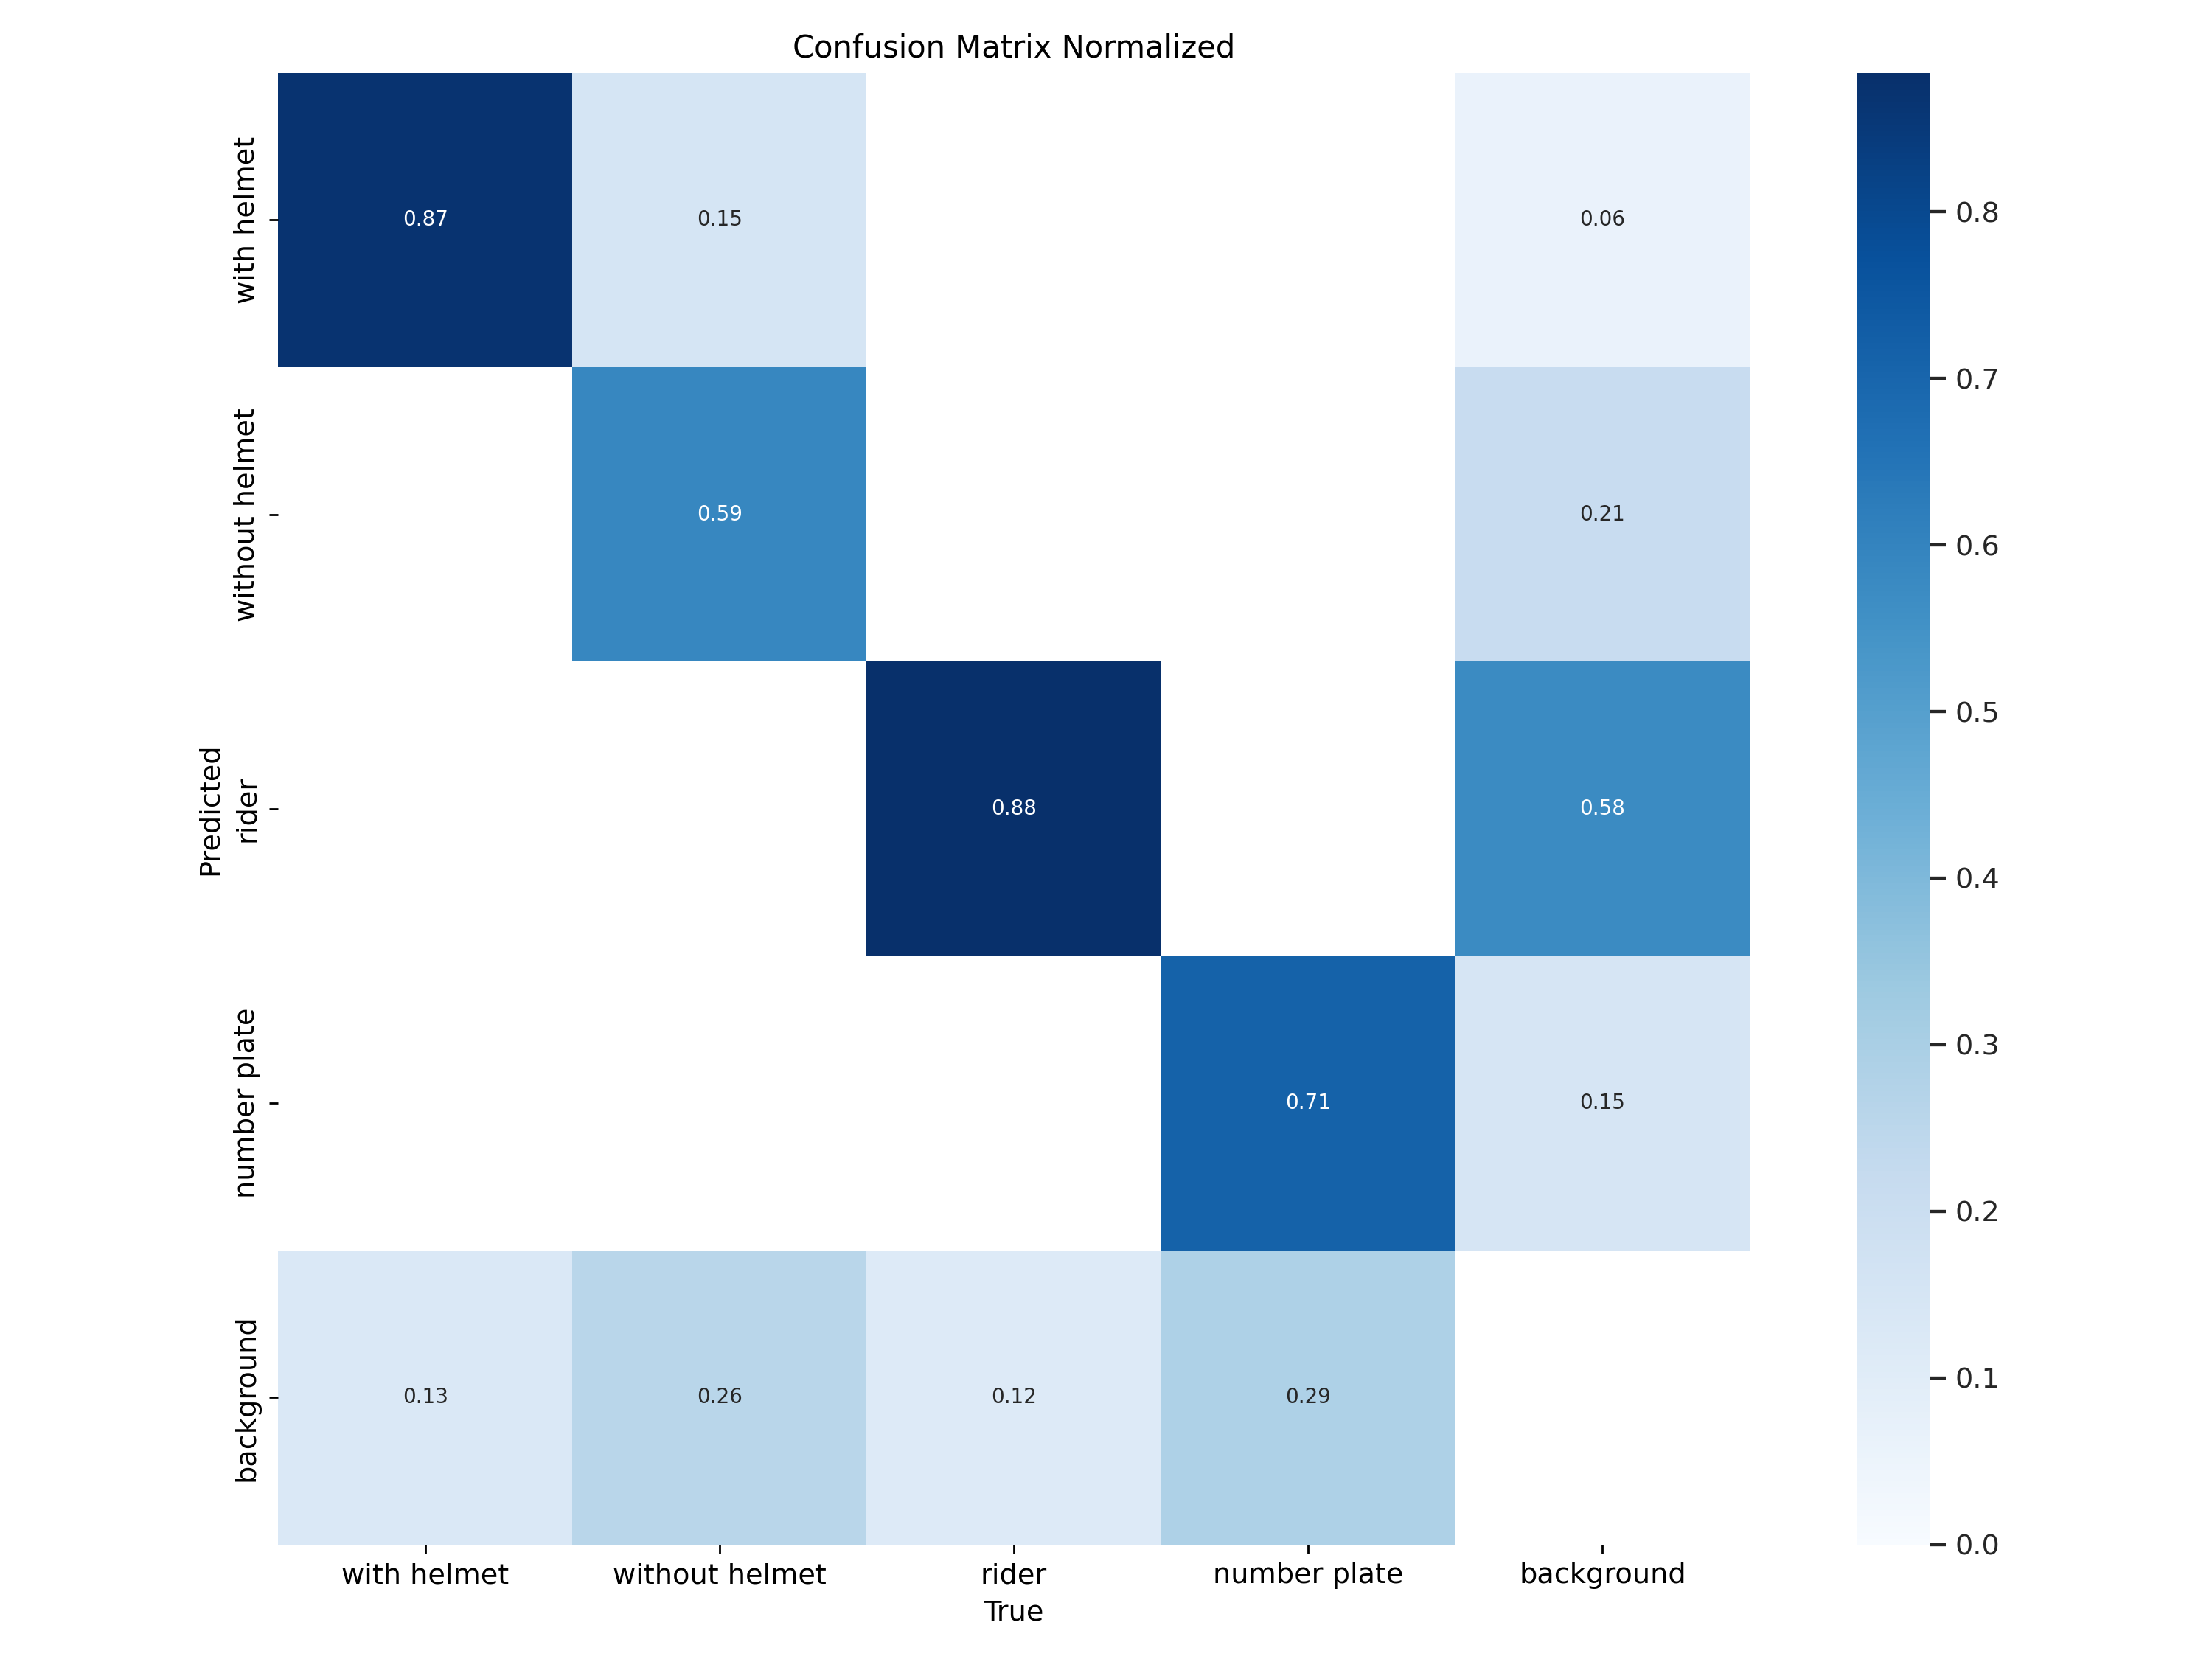

In [19]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train/confusion_matrix_normalized.png')

##Prediction

In [20]:
model = YOLO(' )  # load a custom model

# Predict with the model with any image from internet?
results = model('https://www.freshpoint.com/wp-content/uploads/2019/08/freshpoint-produce-101-apples-bananas.jpg', save=True)

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-20-68f54b539fed>, line 1)

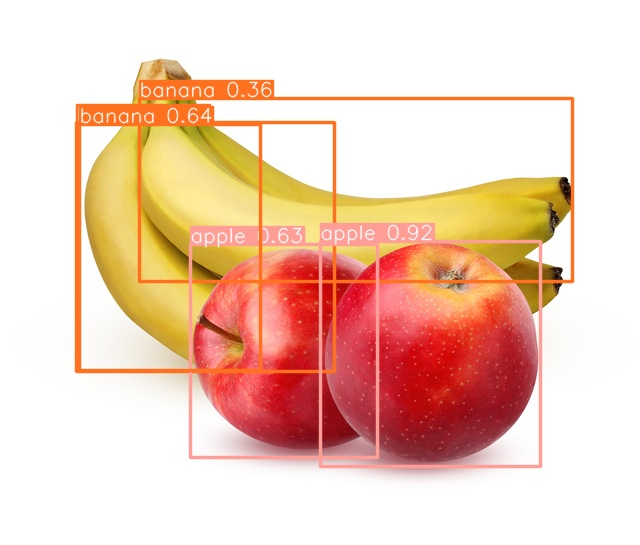

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/freshpoint-produce-101-apples-bananas.jpg')